In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import Data

In [2]:
dataNorm = ad.read_h5ad('/data/rudensky/EYW/SIG04_240816/python_outs/SIG04_merge_singlets_ZscoreNorm_scanpy.h5ad')
dataSCT = ad.read_h5ad('/data/rudensky/EYW/SIG04_240816/python_outs/SIG04_merge_singlets_ZscoreSCT_scanpy.h5ad')

# Correlation Clustering

In [3]:
# Step 1: Subset the highly-variable genes
adata_hv = dataNorm[:, dataNorm.var['highly_variable']]

# Step 2: Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_hv.X.toarray(), index=adata_hv.obs.index, columns=adata_hv.var_names)
df['oBC_feature_call'] = adata_hv.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Step 3: Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

/scratch/lsftmp/9366507.tmpdir/ipykernel_66800/4278773683.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


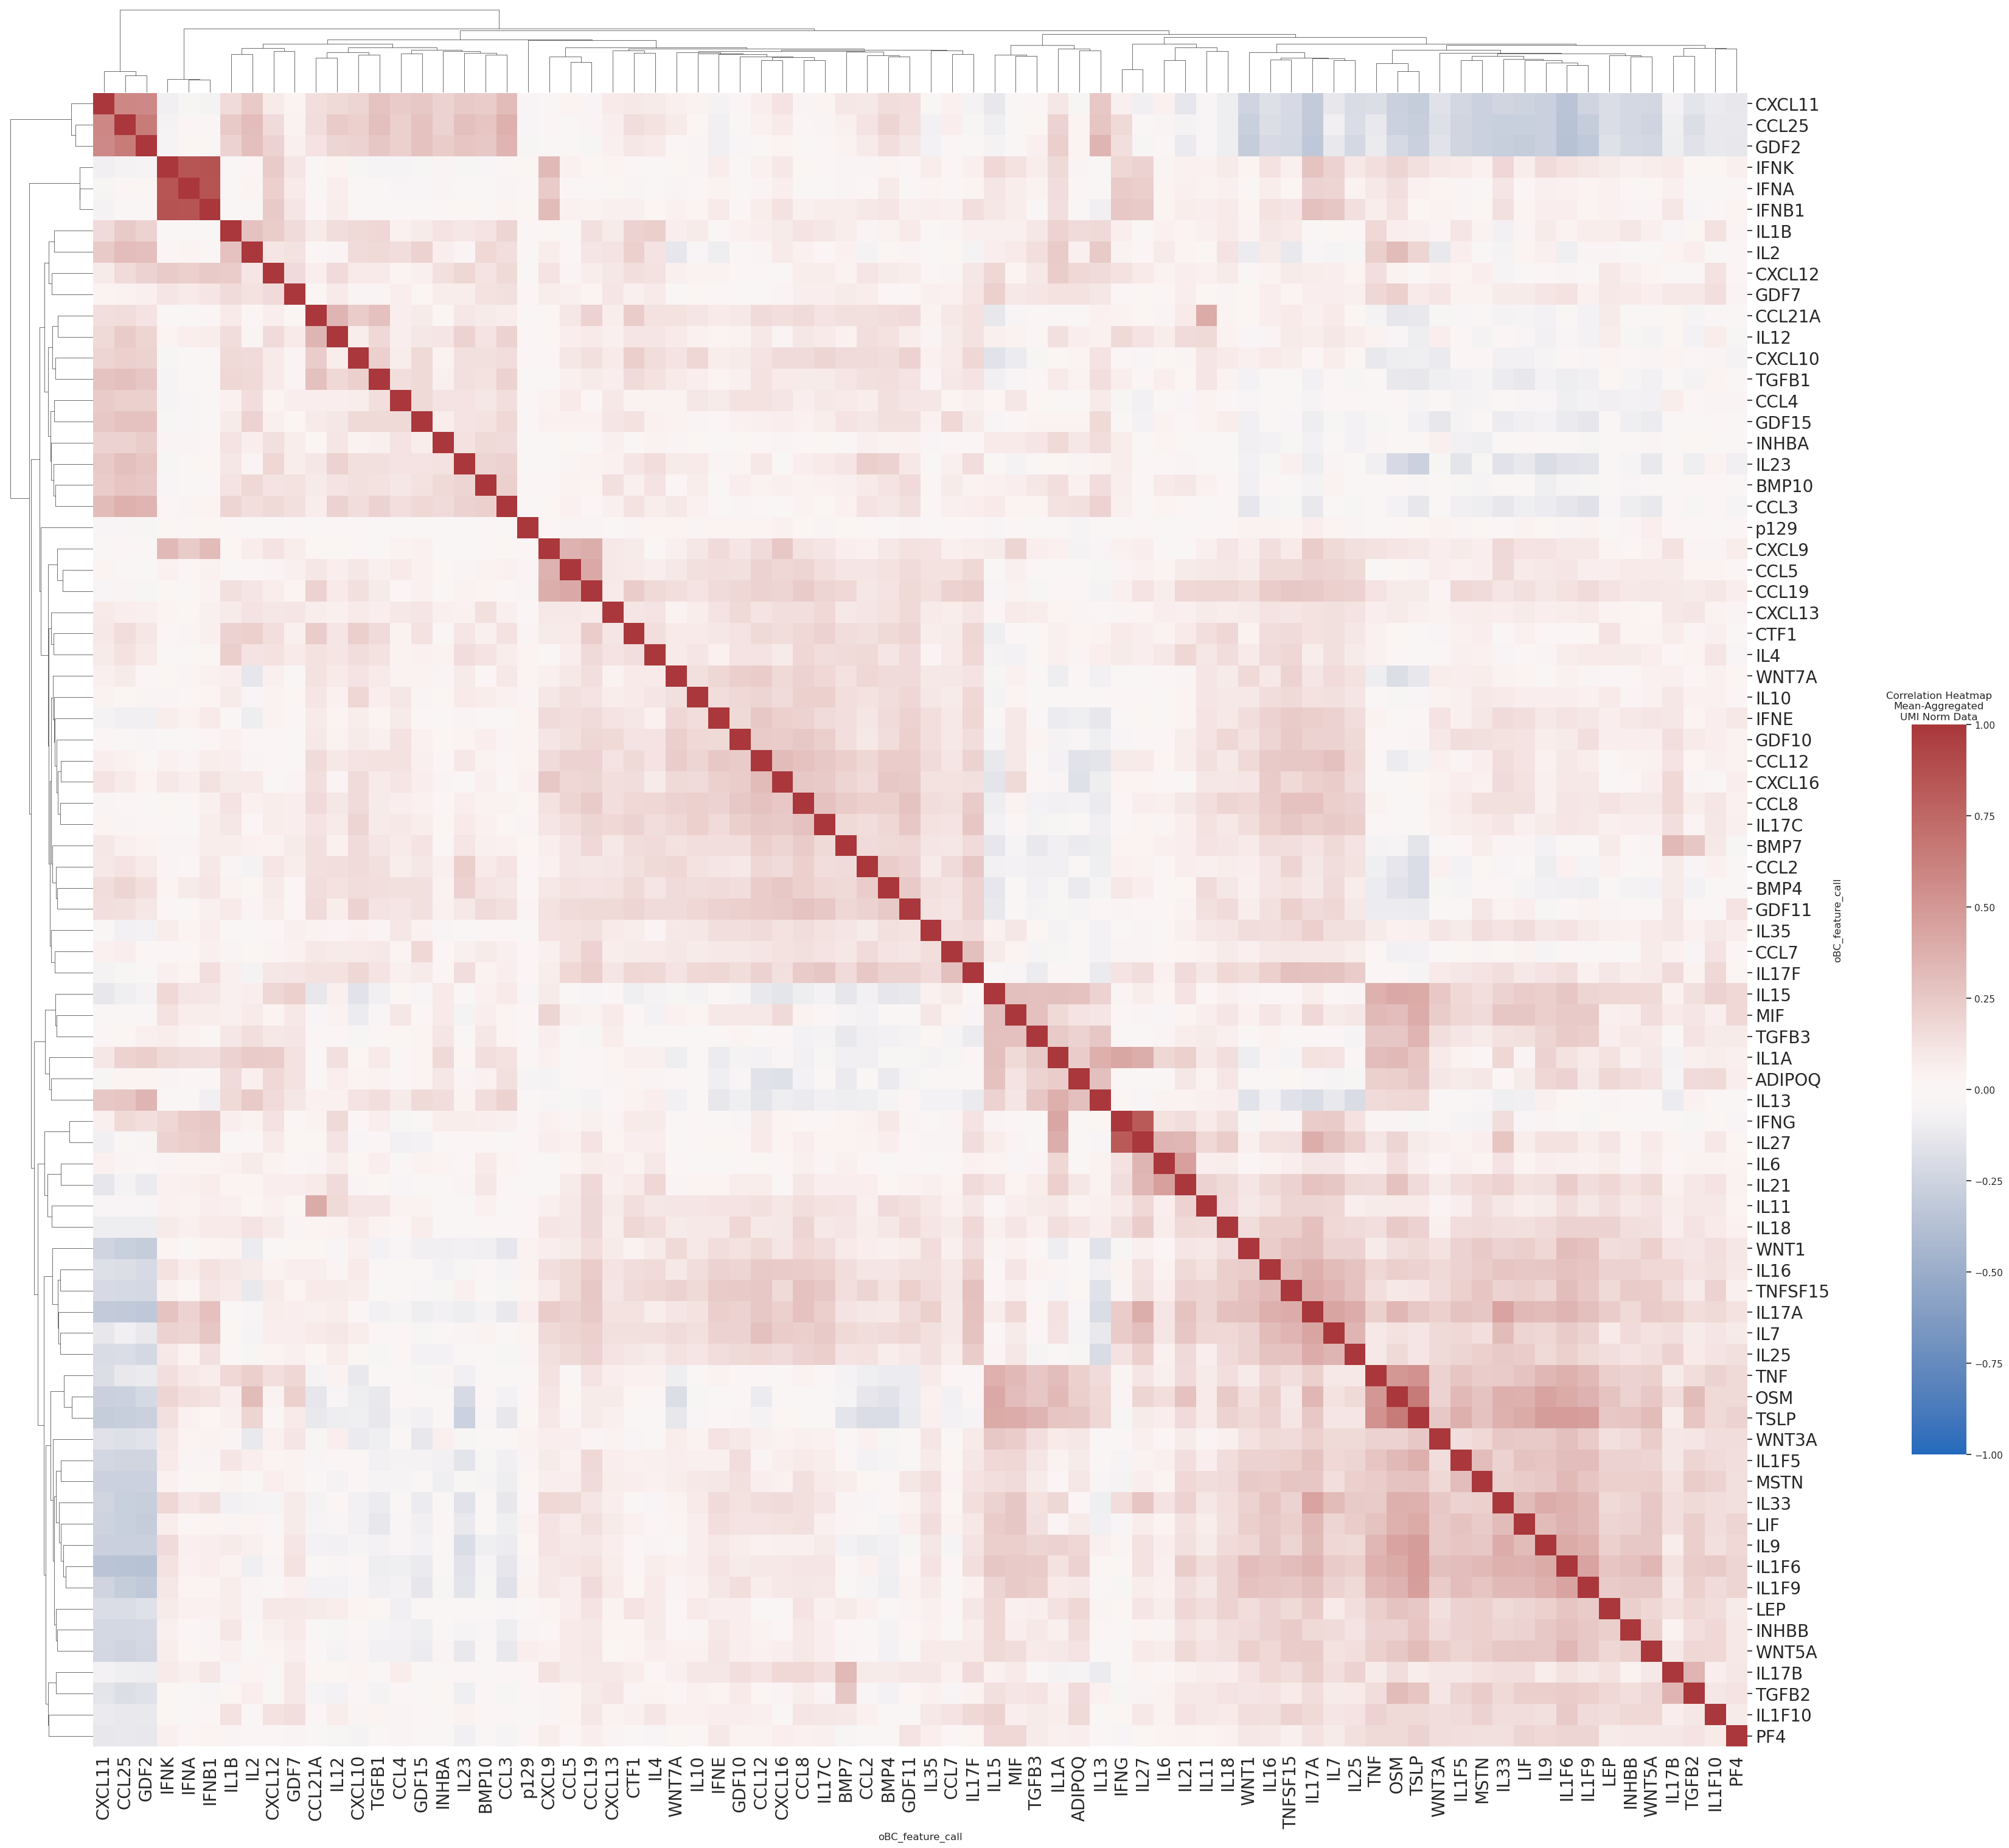

In [33]:
# Step 4: Plot the heatmap using seaborn
sns.set(font_scale=1)  # Adjust the overall font size (for labels, tick marks, etc.)

g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, .05),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(30, 30))

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .4])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)  # Adjust y-tick labels

plt.title('Correlation Heatmap\nMean-Aggregated\nUMI Norm Data')
plt.show()

In [75]:
# Step 1: Subset the highly-variable genes
adata = dataNorm[:,:]
adata_hv = adata[:, adata.var['highly_variable']]

# Step 2: Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Step 3: Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Step 4: Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()
correlation_matrix.index.astype(str)

# Step 5: Load the metadata CSV file (assuming two columns: 'oBC_feature_call' and 'Plate Position')
metadata = pd.read_csv('/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/plate_meta_SIG04.csv')
metadata['oBC_feature_call'] = metadata['oBC_feature_call'].astype(str)
metadata = metadata[~metadata['oBC_feature_call'].str.contains('-pool')]
metadata.set_index('oBC_feature_call', inplace=True)
metadata.index = metadata.index.astype(str)

# Step 6: Merge the metadata with the correlation matrix
merged_data = pd.merge(correlation_matrix, metadata, left_index=True, right_index=True, how='left')

# Step 7: Assign colors to both the 'row' and 'column' metadata for visualization
# Generate color palettes for the 'row' and 'column'
unique_rows = merged_data['row'].unique()
unique_columns = merged_data['column'].unique()

row_palette = sns.color_palette("Set2", len(unique_rows))
column_palette = sns.color_palette("Set1", len(unique_columns))

# Create dictionaries mapping each row and column value to a color
row_colors_dict = dict(zip(unique_rows, row_palette))
column_colors_dict = dict(zip(unique_columns, column_palette))

# Map the colors to the 'row' and 'column' metadata
row_colors = merged_data['row'].map(row_colors_dict)
column_colors = merged_data['column'].map(column_colors_dict)

# Combine both 'row' and 'column' colors into a DataFrame (for multiple row color bars)
row_colors_combined = pd.DataFrame({'row': row_colors, 'column': column_colors})

/scratch/lsftmp/9366507.tmpdir/ipykernel_66800/1249284379.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


InvalidIndexError: slice(None, None, None)

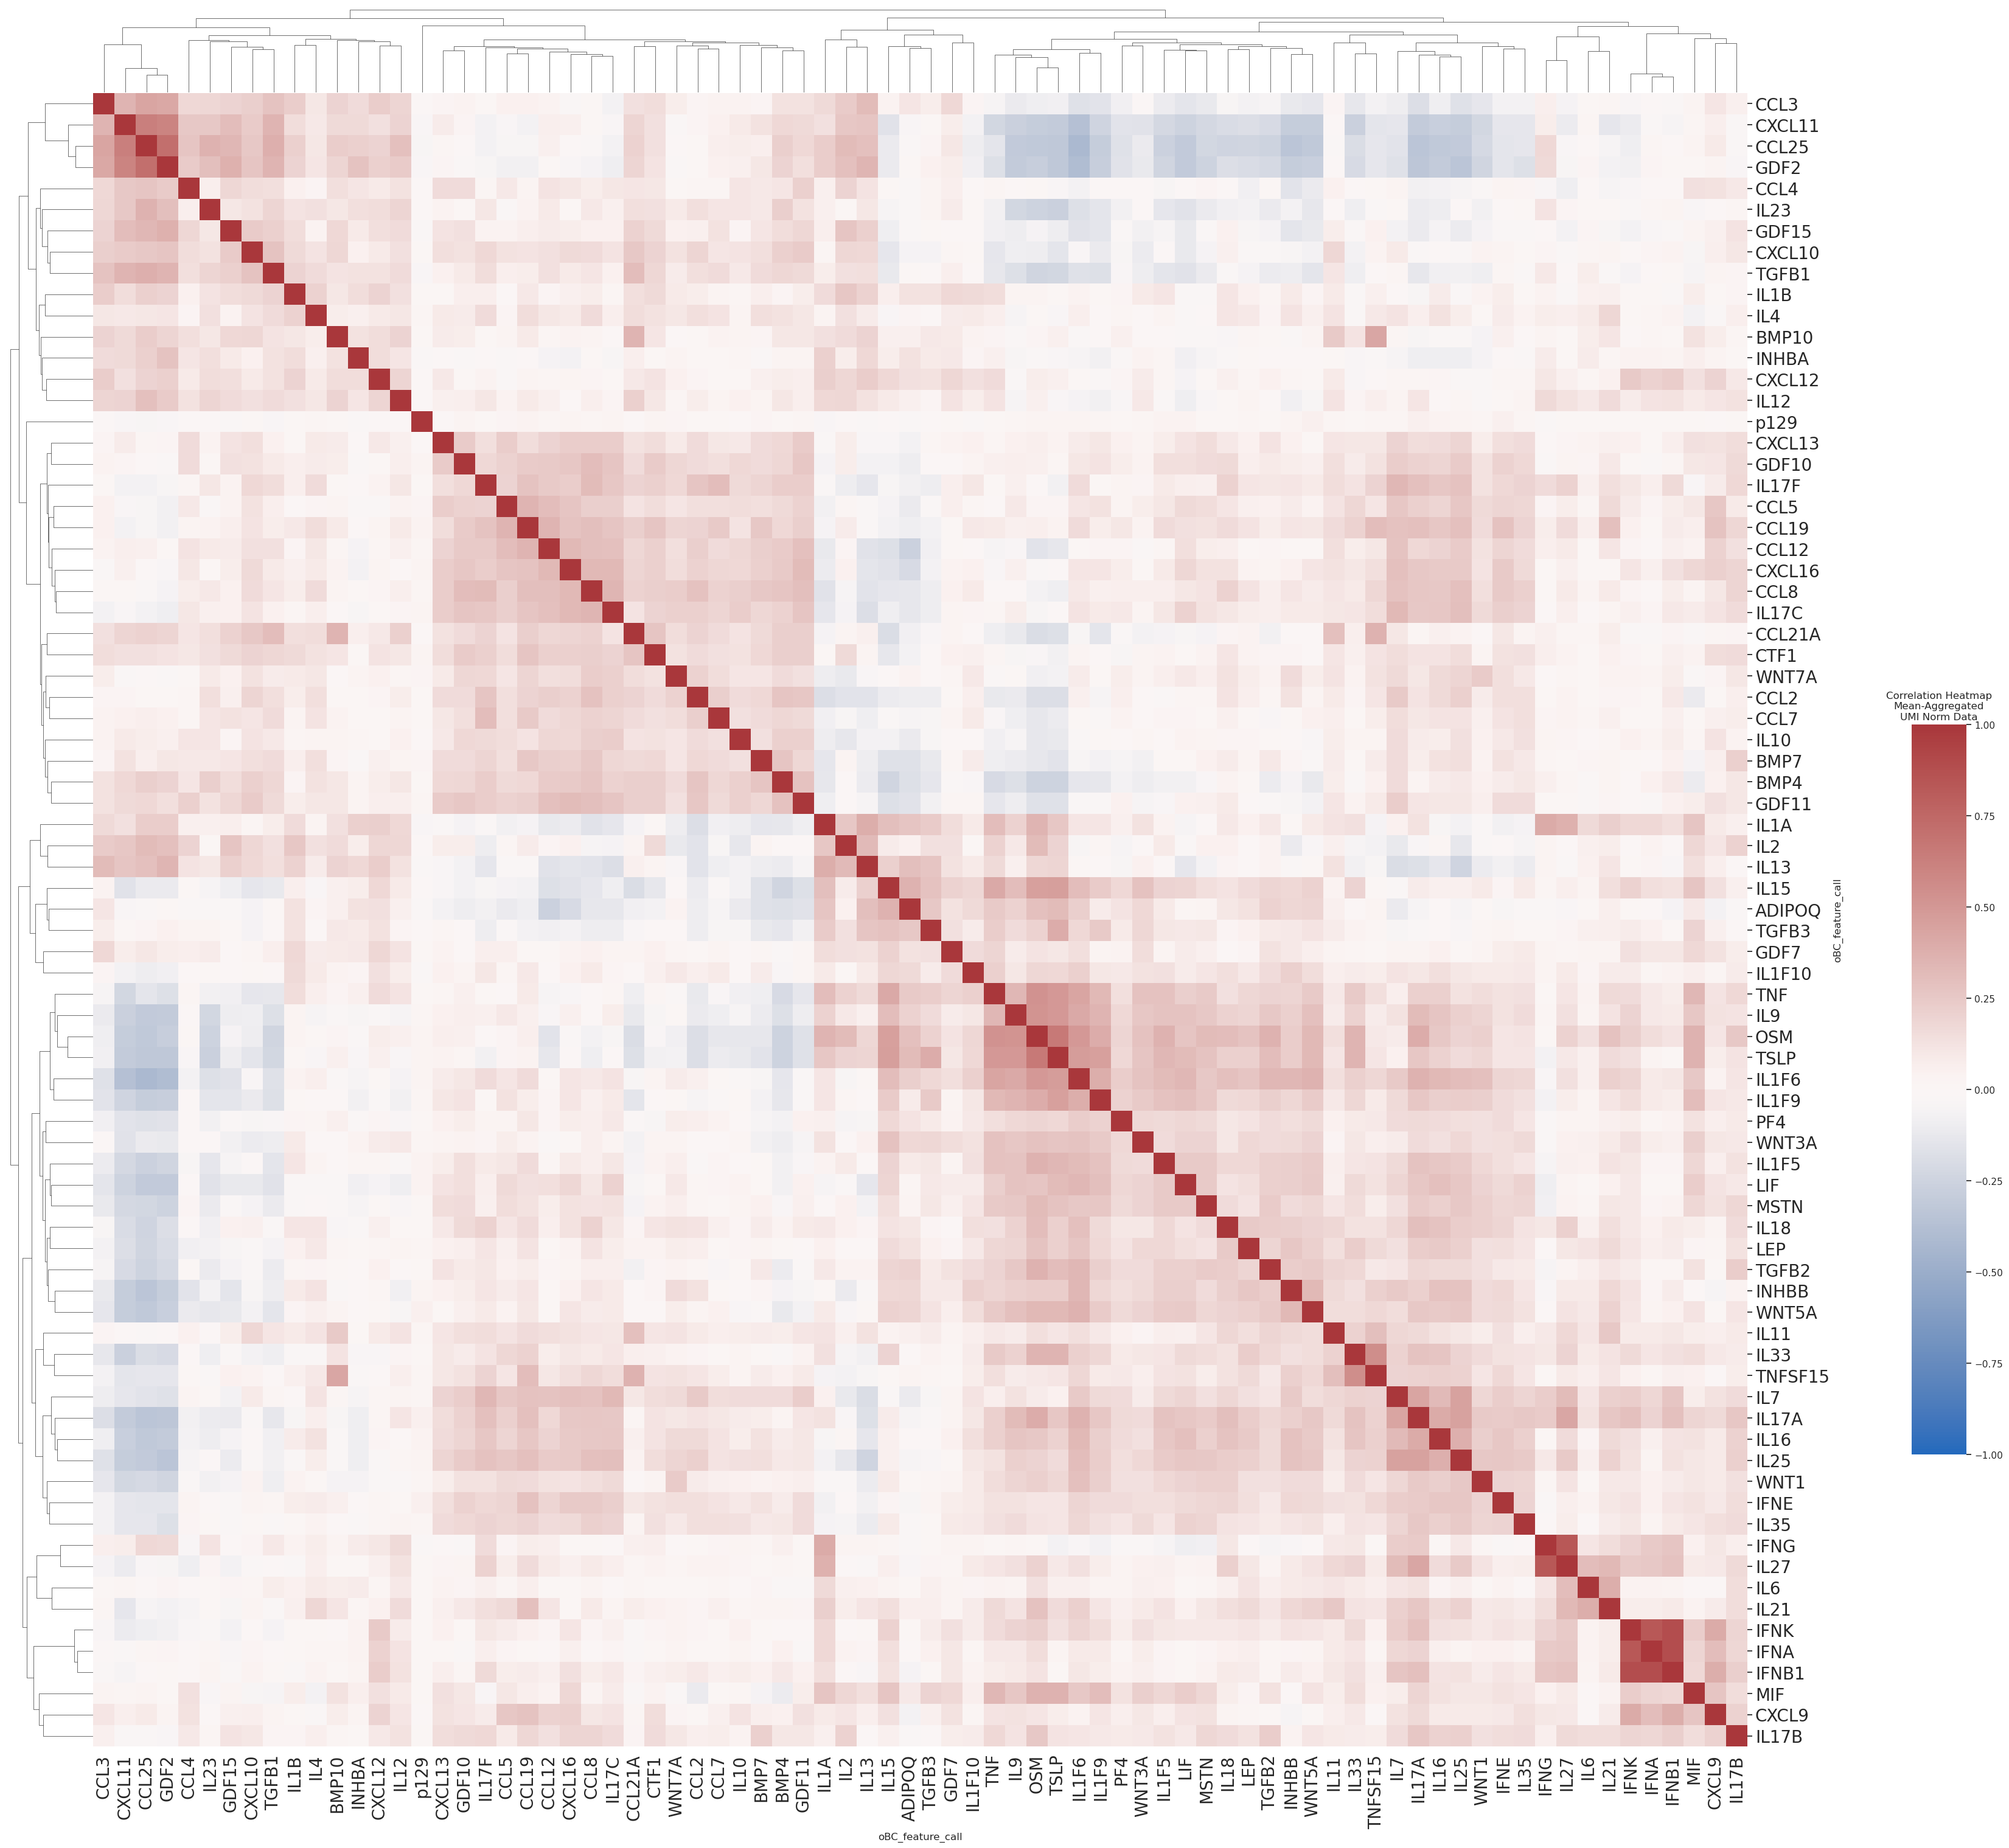

In [35]:
# Step 8: Plot the heatmap using seaborn with both row and column metadata as row colors
sns.set(font_scale=1)

g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, .05),  # Adjusts the width of the dendrogram
                   xticklabels=True, 
                   yticklabels=True, 
                   row_colors=row_colors_combined,  # Adds both 'row' and 'column' metadata as row colors
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5}, 
                   figsize=(30, 30))

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .4])  # Adjust colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)

plt.title('Correlation Heatmap\nMean-Aggregated\nUMI Norm Data')
plt.show()

In [36]:
# Step 1: Subset the highly-variable genes
adata = dataNorm[dataNorm.obs['gem_group'] == "lane2",:]
adata_hv = adata[:, adata.var['highly_variable']]

# Step 2: Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Step 3: Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Step 4: Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

/scratch/lsftmp/9366507.tmpdir/ipykernel_66800/3132045388.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


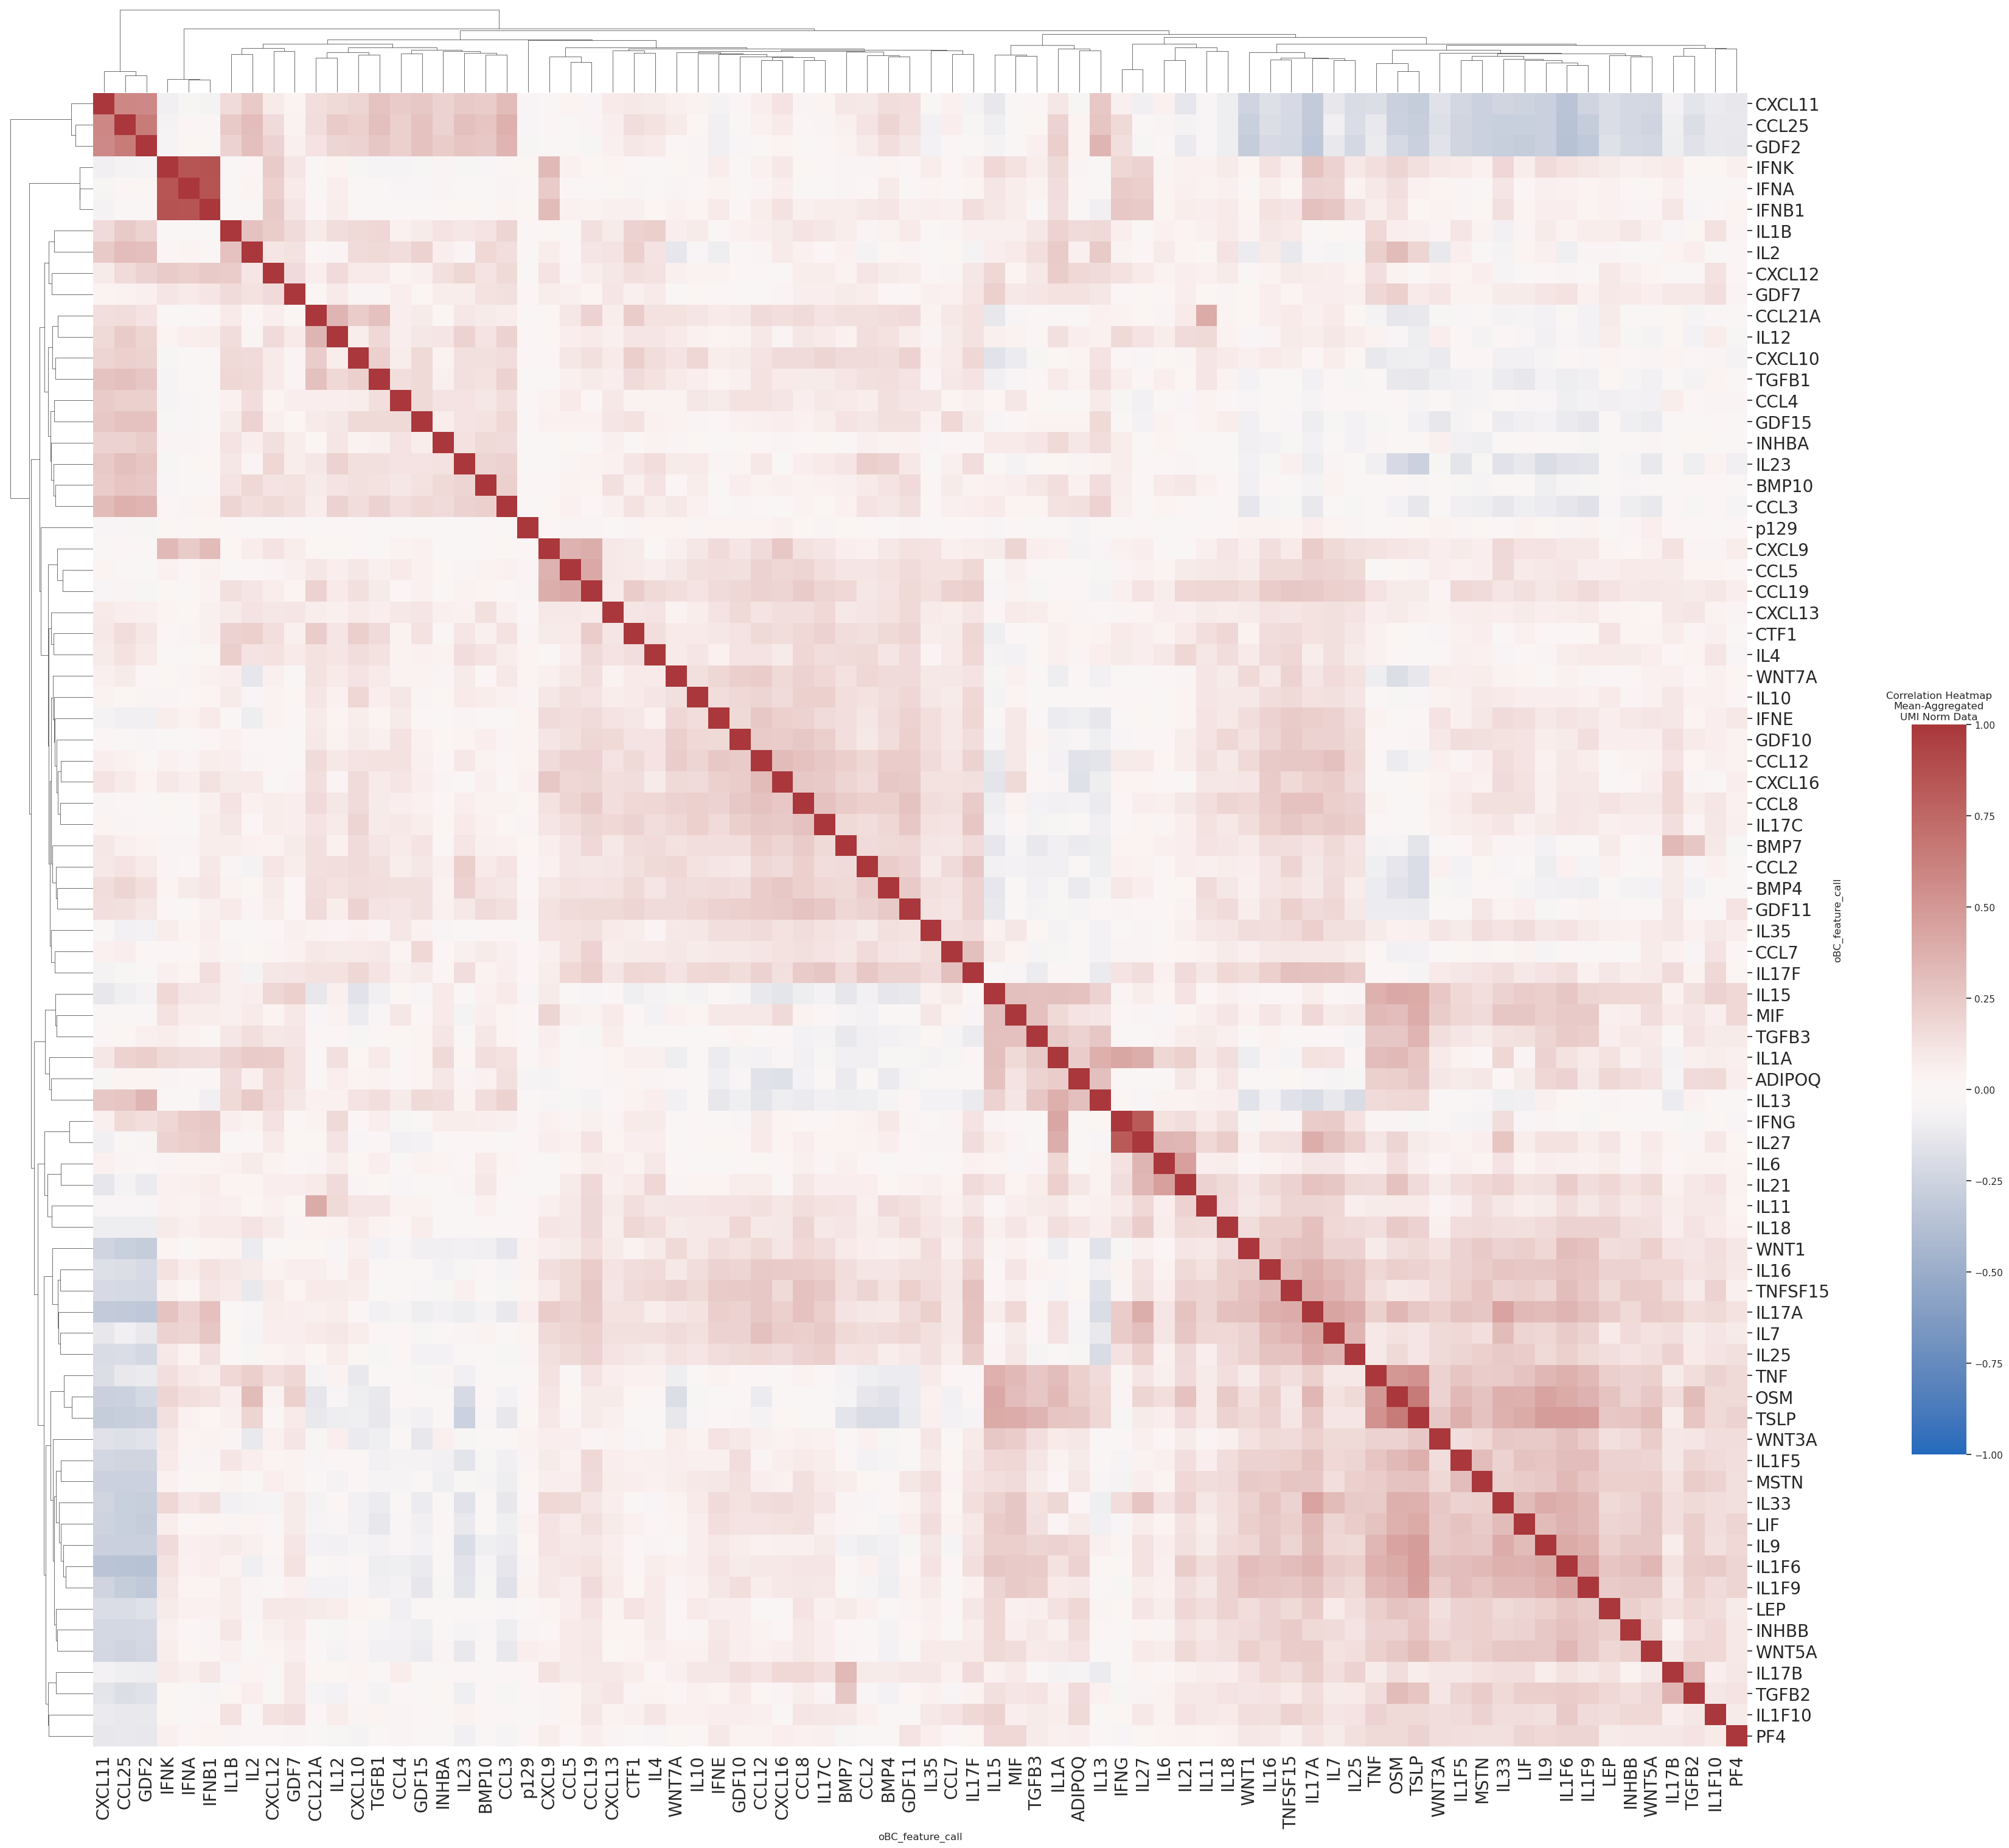

In [37]:
# Step 4: Plot the heatmap using seaborn
sns.set(font_scale=1)  # Adjust the overall font size (for labels, tick marks, etc.)

g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, .05),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(30, 30))

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .4])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)  # Adjust y-tick labels

plt.title('Correlation Heatmap\nMean-Aggregated\nUMI Norm Data')
plt.show()

In [38]:
# Step 1: Subset the highly-variable genes
adata_hv = dataSCT[:, dataSCT.var['highly_variable']]

# Step 2: Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_hv.X.toarray(), index=adata_hv.obs.index, columns=adata_hv.var_names)
df['oBC_feature_call'] = adata_hv.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Step 3: Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

/scratch/lsftmp/9366507.tmpdir/ipykernel_66800/3775768712.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


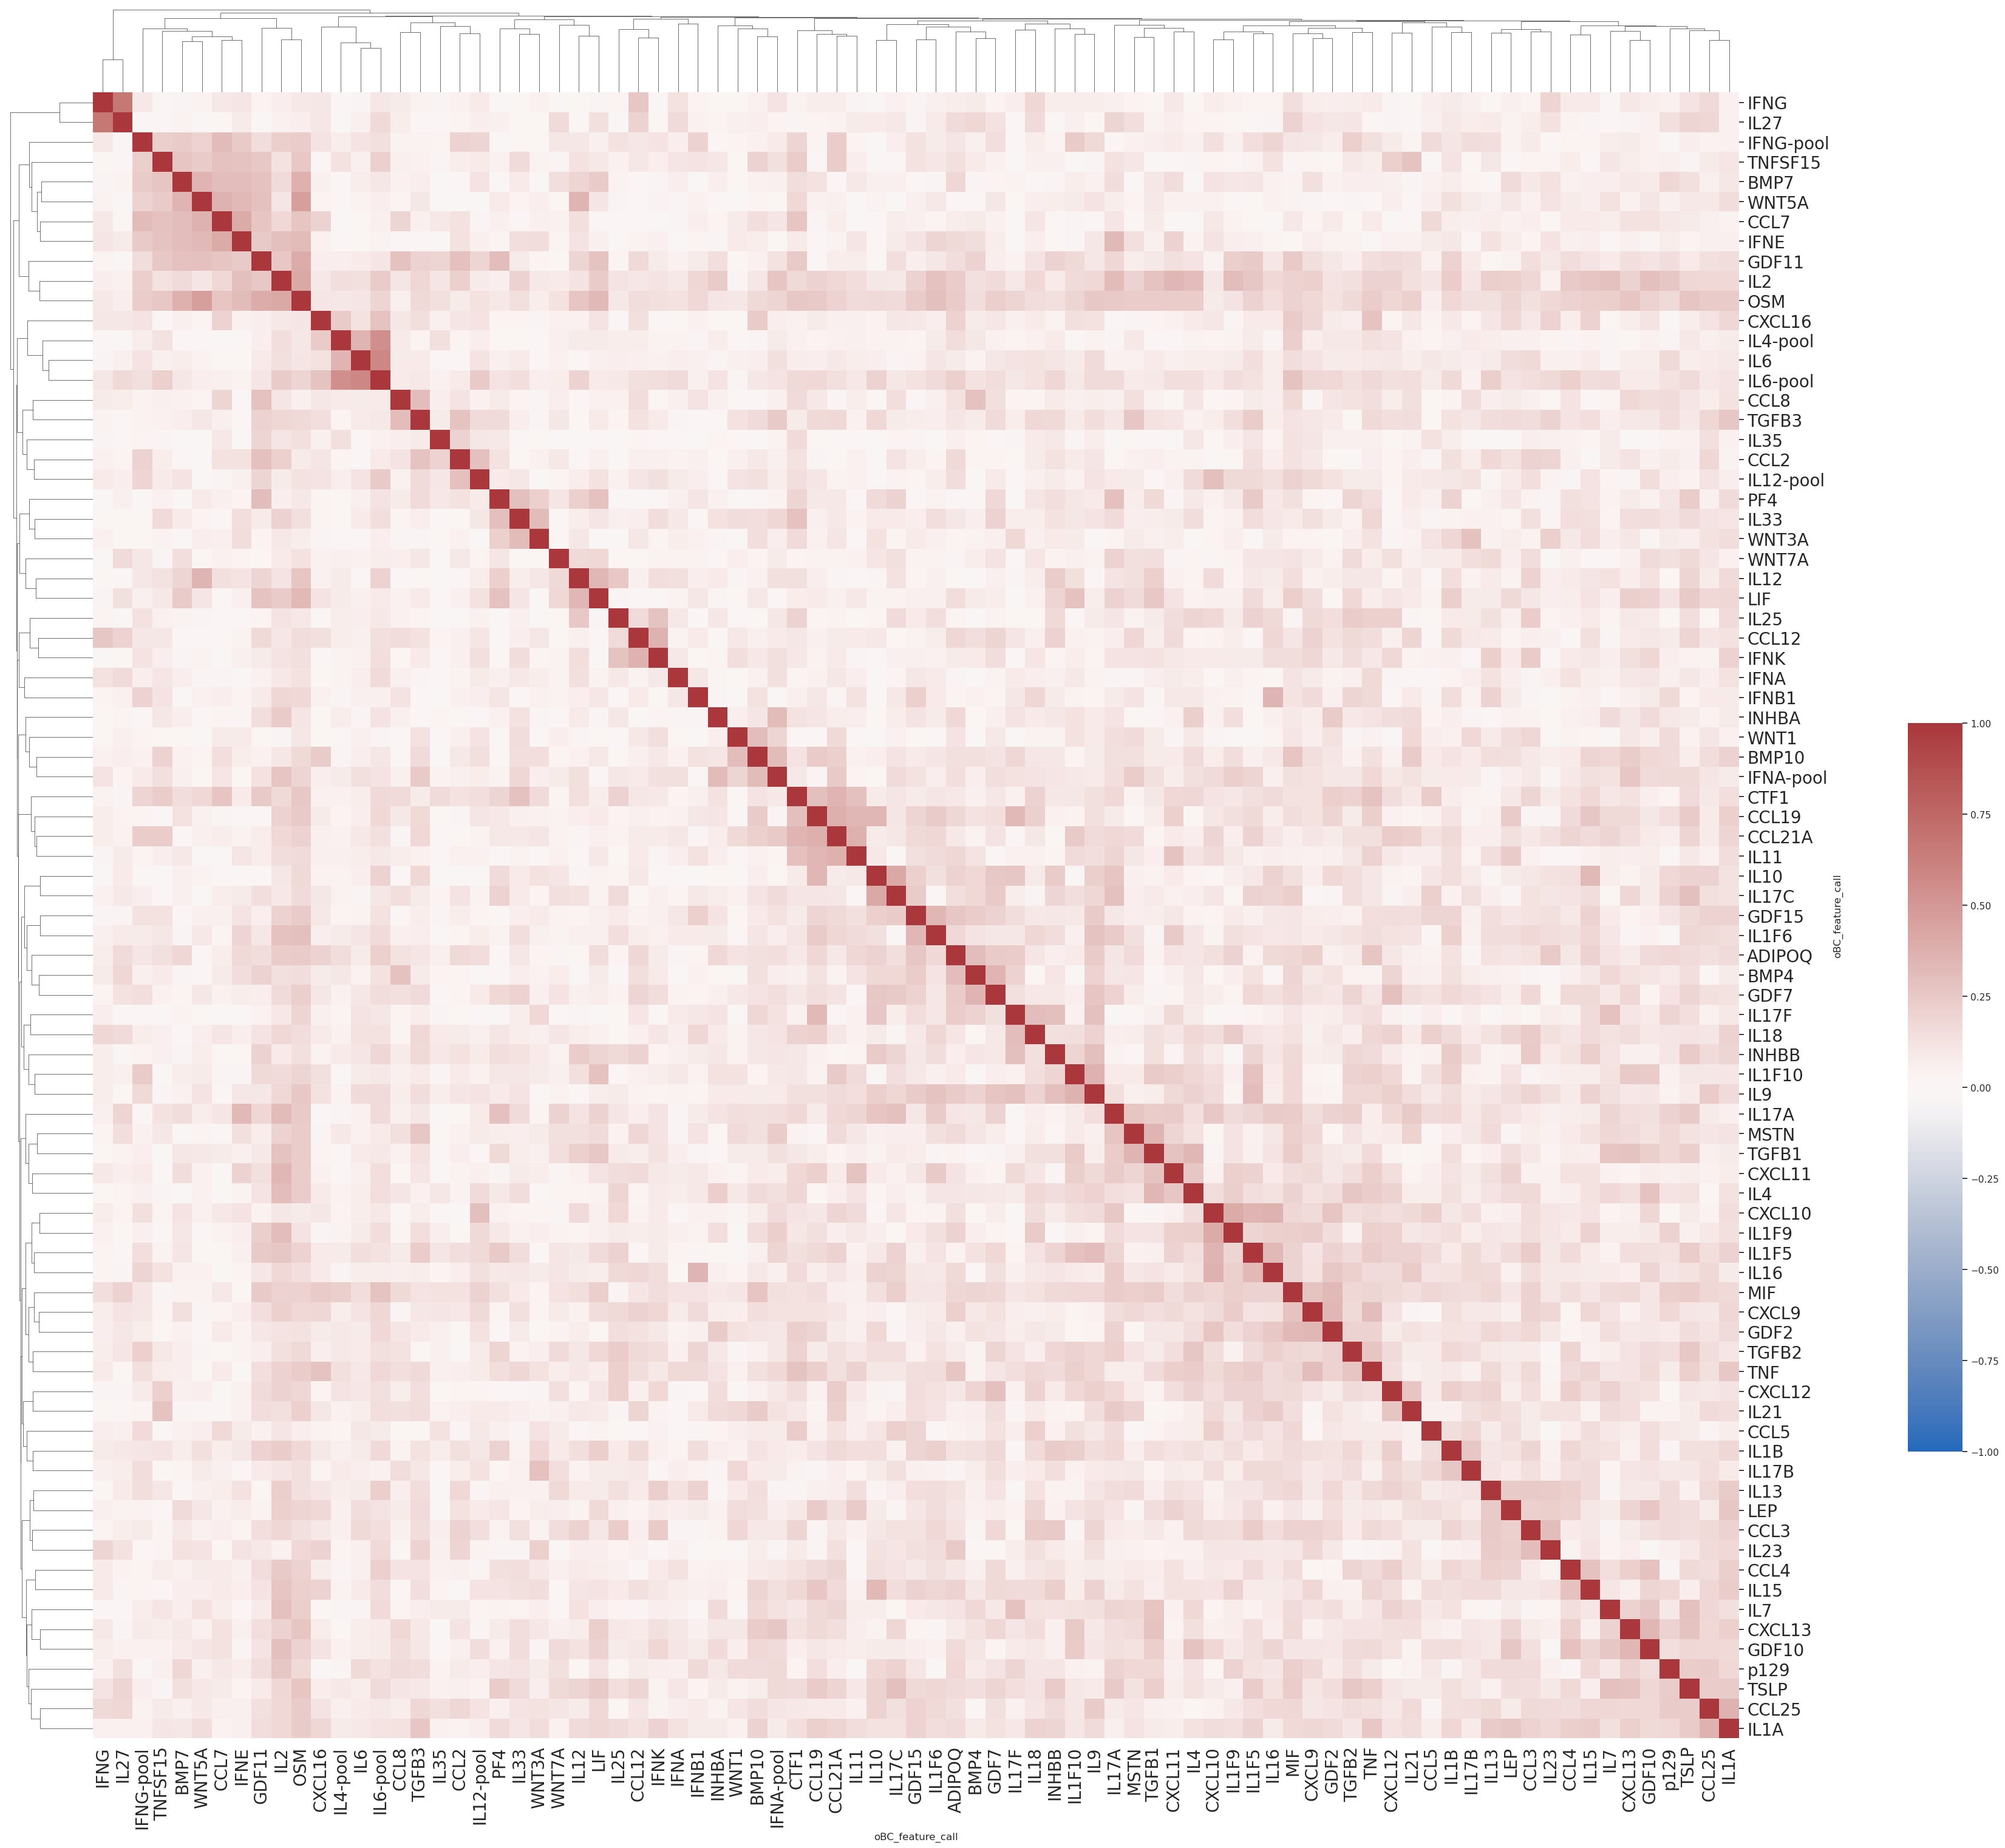

In [ ]:
# Step 4: Plot the heatmap using seaborn
sns.set(font_scale=1)  # Adjust the overall font size (for labels, tick marks, etc.)

g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, .05),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(30, 30))

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .4])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)  # Adjust y-tick labels

plt.show()

In [23]:
# Step 1: Subset the highly-variable genes
adata = dataNorm[dataNorm.obs['gem_group'] == "lane2",:]
adata_hv = adata[:, adata.var['highly_variable']]

# Step 2: Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Step 3: Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Step 4: Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

/scratch/lsftmp/9355588.tmpdir/ipykernel_43350/3132045388.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


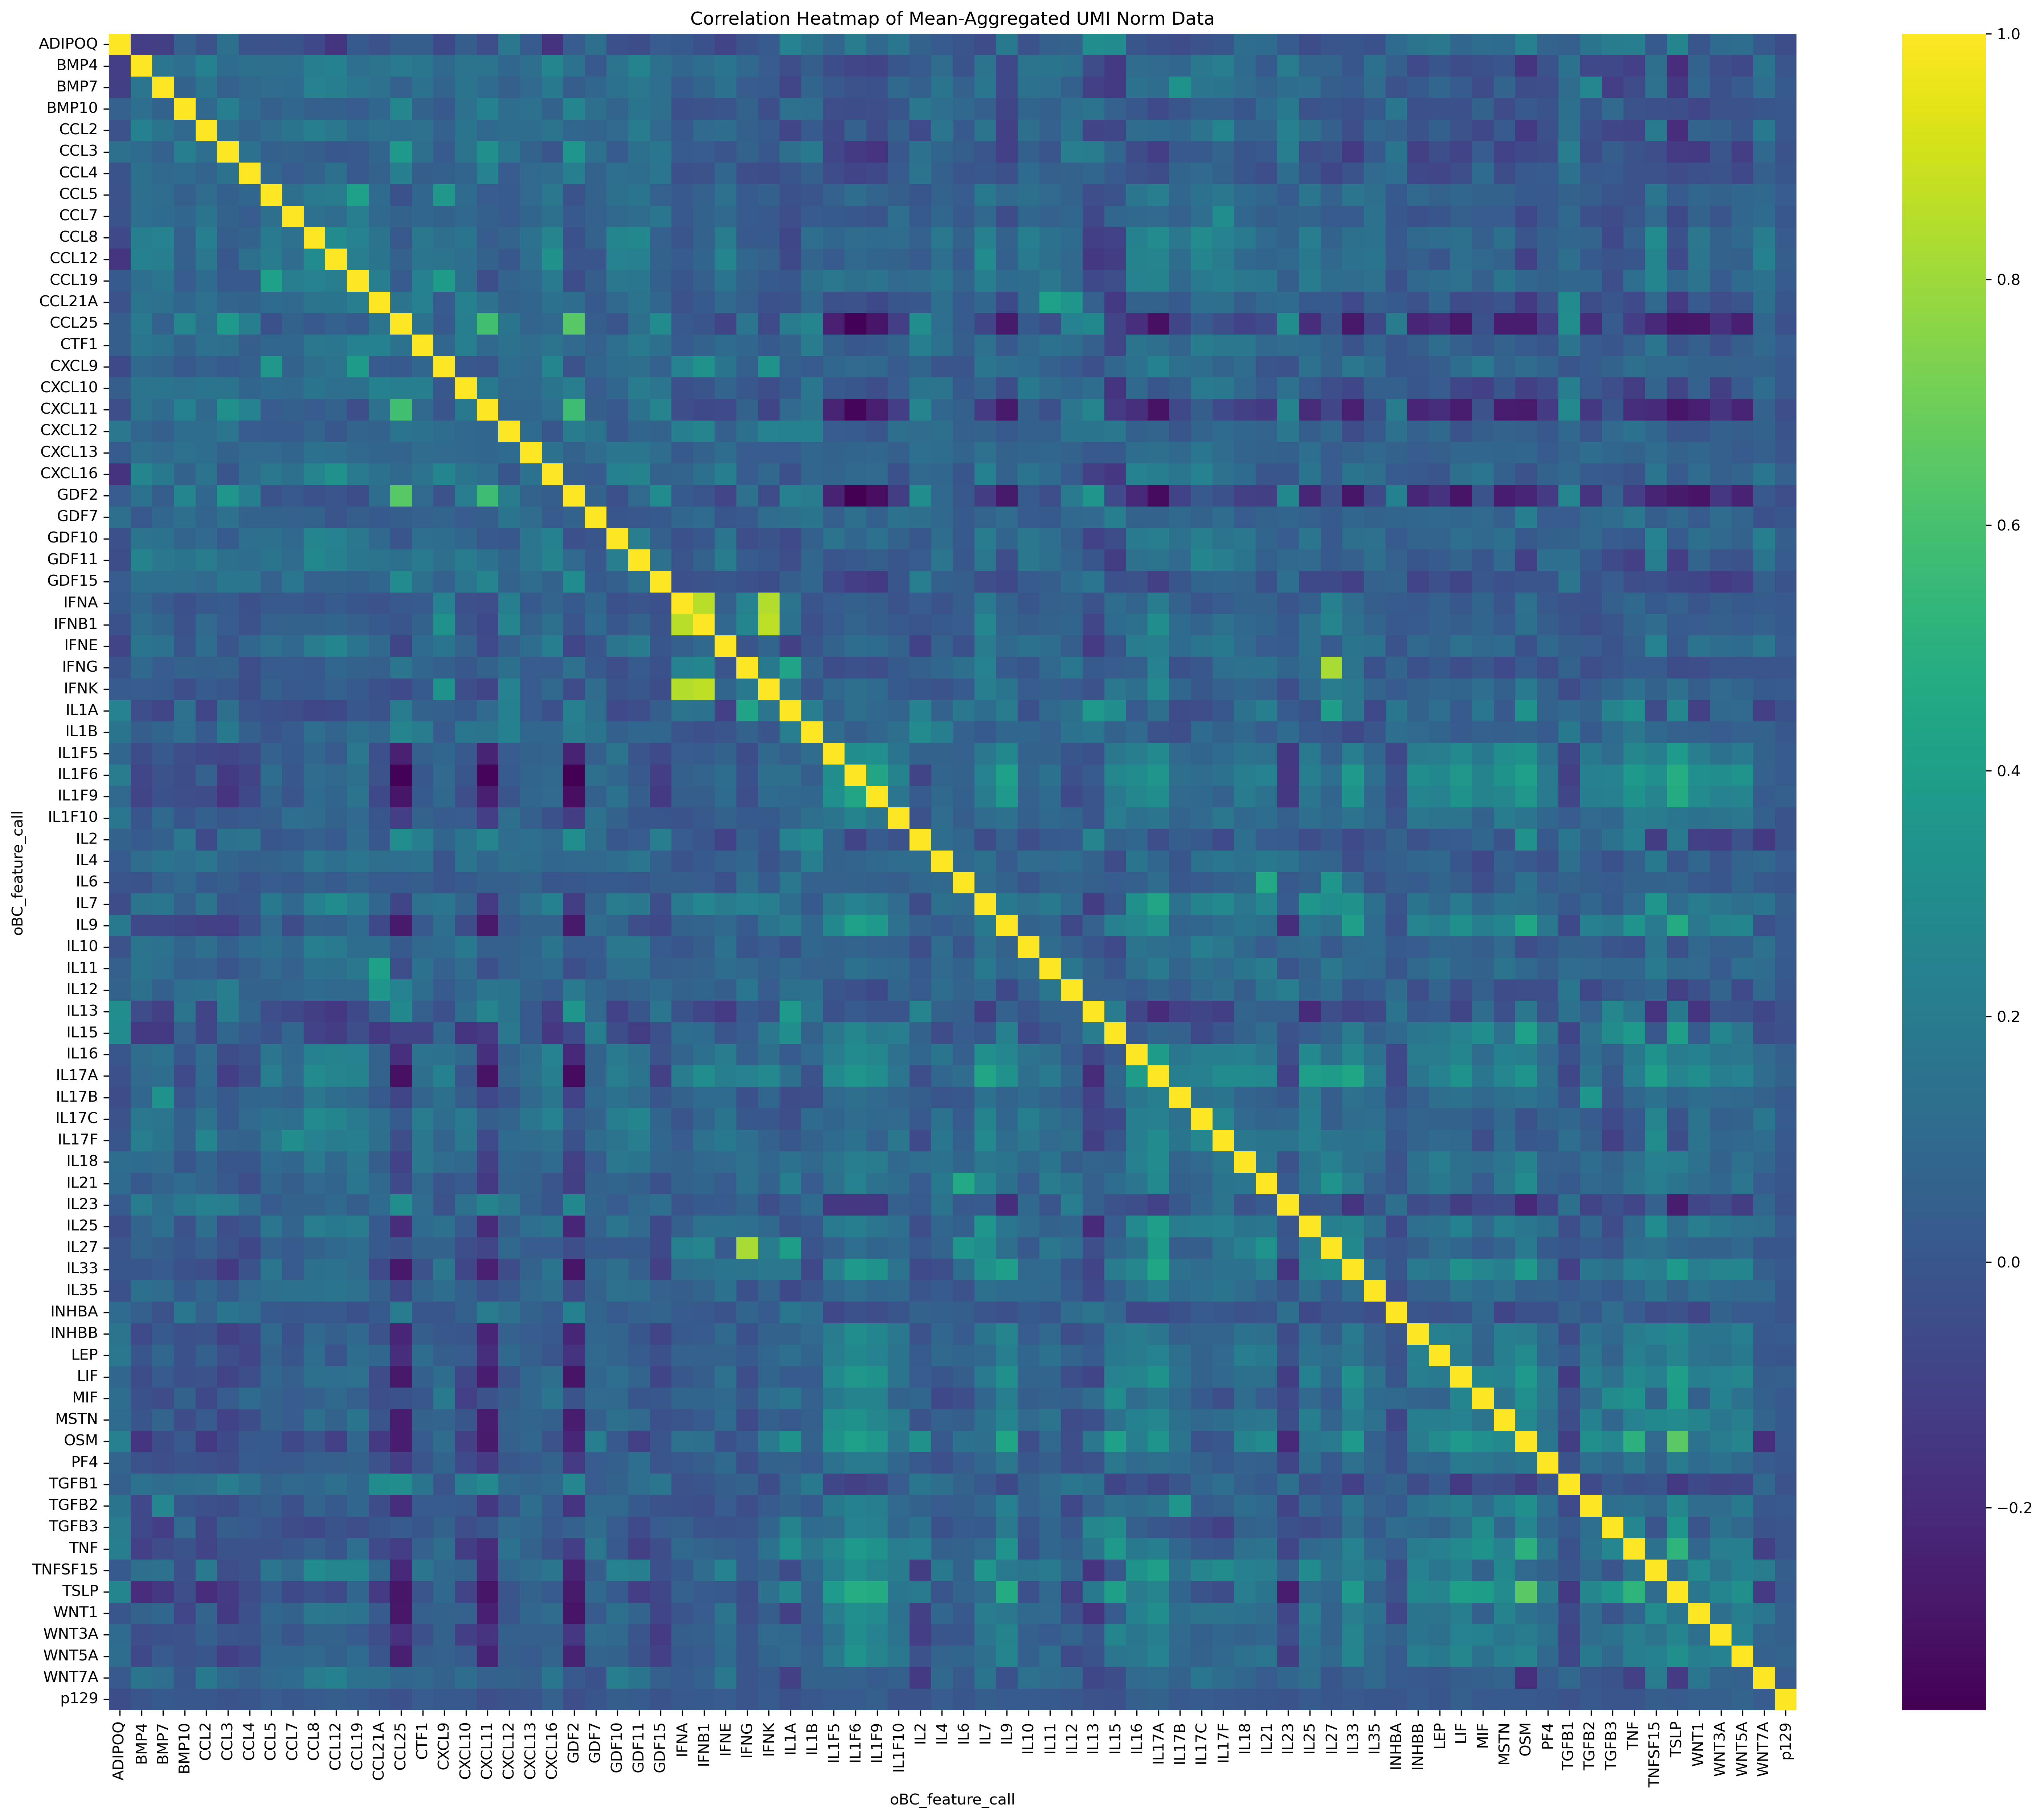

In [24]:
# Step 4: Plot the heatmap using seaborn
plt.figure(figsize=(25, 20), dpi=300)
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Correlation Heatmap of Mean-Aggregated UMI Norm Data')
plt.show()